## Imports and experiment setup

In [1]:
%run header.py
%matplotlib inline

from utils import combine_with_identity

In [ ]:
exp_path = '/nmnt/x04-hdd/boris_temp/SGIMC_IMC/segment/'

In [2]:
PROBLEM = "classification" if True else "regression"

step_fn = step_qaadmm

if PROBLEM == "classification":
    QAObjectiveLoss = QAObjectiveLogLoss
else:
    QAObjectiveLoss = QAObjectiveL2Loss  # QAObjectiveHuberLoss

In [3]:
C_ridge = 1e-4
Cs_group = [2e-1, 2e-2, 2e-3, 2e-4, 2e-5]
eta = 1e0

## Parameter to vary

In [4]:
elements = [0.0005, 0.001, 0.002, 0.003, 0.005, 0.007, 0.01, 0.015, 0.02]

## Data loading

In [5]:
exp_path = '/nmnt/x04-hdd/boris_temp/SGIMC_IMC/segment/'

R_full = np.load(exp_path + 'R.npy')
X = np.load(exp_path + 'X.npy')

Y = np.eye(len(R_full))
y_mask = np.array(Y, dtype='bool')
Y = sparsify_with_mask(Y, y_mask)

## Run experiment (K = 5 )

In [6]:
K = 5 # K = X.shape[1]
n_iter = 100

In [9]:
accs = []
for n in tqdm(elements):
    R_train, mask = sparsify(R_full, n, random_state=random_state)
    problem = IMCProblem(QAObjectiveLoss, X, Y, R_train, n_threads=8)

    C_accuracies = []
    for C_group in Cs_group:
        C_lasso = 10 * C_group
        C = (C_lasso, C_group, C_ridge)
        step_kwargs = {
            "C": C,                 # the regularizr constants (C_lasso, C_group, C_ridge)
            "eta": eta,             # the eta of the ADMM (larger - faster but more unstable)
            "rtol": 1e-2,           # the relative tolerance for stopping the ADMM
            "atol": 1e-4,           # the absolute tolerance
            "method": "tron",       # the method to use in Sub_0
            "n_iterations": 2,      # the number of iterations of the inner ADMM
        }

        W_0 = random_state.normal(size=(X.shape[1], K))
        H_0 = random_state.normal(size=(Y.shape[1], K))

        W, H = W_0.copy(), H_0.copy()

        W, H = imc_descent(problem, W, H,
                           step_fn,                  # the inner optimization
                           step_kwargs=step_kwargs,  # asrtguments for the inner optimizer
                           n_iterations=n_iter,      # the number of outer iterations (Gauss-Siedel)
                           n_init_iterations=0,
                           return_history=True,      # Record the evolution of the matrices (W, H)
                           rtol=1e-3,                # relative stopping tolerance for the outer iterations
                           atol=1e-5,                # absolute tolerance
                           verbose=False,            # show the progress bar
                           check_product=True,       # use the product W H' for stopping
                           )

        R_hat = get_prediction(X, W, H, Y, binarize=True)
        acc = accuracy(R_full, R_hat, invert(mask))
        C_accuracies.append(acc)
    accs.append(np.max(C_accuracies))
    
accs = np.array(accs)
np.save(exp_path + 'results_sgimc_accuracies.npy', accs)

100%|██████████| 9/9 [09:52<00:00, 100.28s/it]


## Features + identity

In [7]:
X_comb = combine_with_identity(X)

In [11]:
accs = []
for n in tqdm(elements):
    R_train, mask = sparsify(R_full, n, random_state=random_state)
    problem = IMCProblem(QAObjectiveLoss, X_comb, Y, R_train, n_threads=8)

    C_accuracies = []
    for C_group in Cs_group:
        C_lasso = 10 * C_group
        C = (C_lasso, C_group, C_ridge)
        step_kwargs = {
            "C": C,                 # the regularizr constants (C_lasso, C_group, C_ridge)
            "eta": eta,             # the eta of the ADMM (larger - faster but more unstable)
            "rtol": 1e-2,           # the relative tolerance for stopping the ADMM
            "atol": 1e-4,           # the absolute tolerance
            "method": "tron",       # the method to use in Sub_0
            "n_iterations": 2,      # the number of iterations of the inner ADMM
        }

        W_0 = random_state.normal(size=(X_comb.shape[1], K))
        H_0 = random_state.normal(size=(Y.shape[1], K))

        W, H = W_0.copy(), H_0.copy()

        W, H = imc_descent(problem, W, H,
                           step_fn,                  # the inner optimization
                           step_kwargs=step_kwargs,  # asrtguments for the inner optimizer
                           n_iterations=n_iter,      # the number of outer iterations (Gauss-Siedel)
                           n_init_iterations=0,
                           return_history=True,      # Record the evolution of the matrices (W, H)
                           rtol=1e-3,                # relative stopping tolerance for the outer iterations
                           atol=1e-5,                # absolute tolerance
                           verbose=False,            # show the progress bar
                           check_product=True,       # use the product W H' for stopping
                           )

        R_hat = get_prediction(X_comb, W, H, Y, binarize=True)
        acc = accuracy(R_full, R_hat, invert(mask))
        C_accuracies.append(acc)
    accs.append(np.max(C_accuracies))
    
accs = np.array(accs)
np.save(exp_path + 'results_sgimc_accuracies_comb.npy', accs)

100%|██████████| 9/9 [08:43<00:00, 84.39s/it]


## Plots

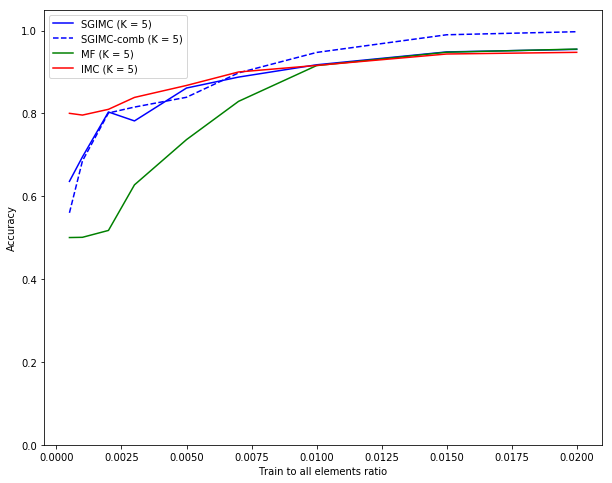

In [16]:
accuracies_sgimc = np.load(exp_path + 'results_sgimc_accuracies.npy')
accuracies_sgimc_comb = np.load(exp_path + 'results_sgimc_accuracies_comb.npy')
accuracies_mf = np.load(exp_path + 'results_mf_accuracies.npy')
accuracies_imc = np.load(exp_path + 'results_imc_accuracies.npy')

plt.figure(figsize=(10,8))
plt.plot(elements, accuracies_sgimc, 'b-', label='SGIMC (K = 5)')
plt.plot(elements, accuracies_sgimc_comb, 'b--', label='SGIMC-comb (K = 5)')
plt.plot(elements, accuracies_mf, 'g-', label='MF (K = 5)')
plt.plot(elements, accuracies_imc, 'r-', label='IMC (K = 5)')
plt.ylim((0,1.05))

plt.xlabel('Train to all elements ratio')
plt.ylabel('Accuracy')
plt.legend()

plt.show()